In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from scipy.stats import norm

In [8]:
import numpy.matlib as npm

In [34]:
# 1 - US T-notes
# 2 - US T-Bonds
# 3 - S&P 500
# 4 - Commodities(golds)
# 5 - EM Stocks

                          #1      2      3      4      5
corr_matrix = np.array([[1.00,  0.91, -0.43, 0.30, 0.22],  # 1
                        [0.91,  1.00, -0.46, 0.21, 0.15],  # 2
                        [-0.43, -0.46, 1.00, 0.02,0.42],  # 3
                        [0.30,  0.21, 0.02, 1.00, 0.27],  # 4
                        [0.22,  0.15, 0.42, 0.27, 1.00]]) # 5

exp_ret = np.array([0.0458, 0.0831, 0.1318, 0.0325, 0.0591])
vol =     np.array([0.0588, 0.1325, 0.1397, 0.1478, 0.0757])

cov_matrix = np.zeros((5,5))
for i, row in enumerate(corr_matrix):
    for j, col in enumerate(row):
        cov_matrix[i, j] = col*vol[i]*vol[j]

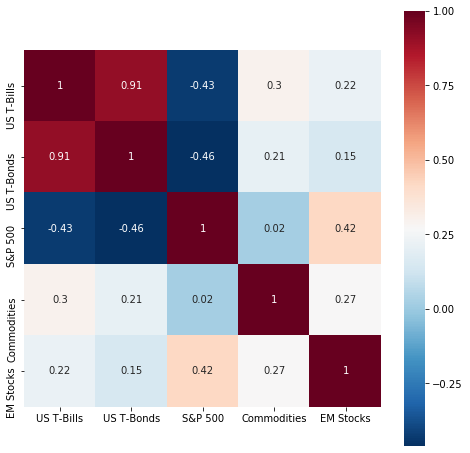

In [35]:
# Plot the correlation matrix
asset_names = ['US T-Bills', 'US T-Bonds', 'S&P 500', 'Commodities', 'EM Stocks']
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix, square=True, cmap="RdBu_r", annot=True, 
            xticklabels=asset_names, yticklabels=asset_names);
plt.savefig(fname='asset_corr_matrix', dpi=150)

In [36]:
W0 = np.array([0.1, 0.2, 0.5, 0.1, 0.2])

def ret_var(W, cov_matrix, exp_ret):
    return -np.dot(exp_ret, W) + (W@cov_matrix@W.T)

In [41]:
# Find the optimal portfolio using mean variance optimization and return the optimal weights, W

def optimize_portfolio(W0, cov_matrix, exp_ret, vol, verbose):
    args = (cov_matrix, exp_ret)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},                 # weights must sum to 1
                   {'type': 'eq', 'fun': lambda x: (x@cov_matrix@x.T)**0.5 - vol}) # vol must = 0.10
    bounds = tuple((0,1) for asset in range(W0.shape[0]))                          # no shorts

    # Run the optimizer 
    optimal = minimize(ret_var, W0, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    W = optimal.x

    W_dict = {'T_Bills': W[0],
              'T_Bonds': W[1],
              'LC_Stocks': W[2],
              'Commodities': W[3],
              'EM_Stocks': W[4]}
    if verbose:
        #print(W_dict, '\n')
        #print(np.sum(W), '\n')
        print('Expected Return: %.3f' % np.dot(W,exp_ret))
        print('Expected Volatility: %.3f' % (W@cov_matrix@W.T)**0.5)
        print('Percent Invested in Stocks: %.3f' % np.sum(W[2:]))
    return W_dict, W

In [44]:
# Portfolio Simulation
pre_ret = 5             #
post_ret = 25
N = pre_ret + post_ret
start_wealth = 500 
spend = 80              # in $USD Thousands
sims = 5000

# Cholesky matrix to transform uncorrelated random variables into correlated ones
L = np.linalg.cholesky(corr_matrix)

# Generate portfolio returns from correlated, random variables
# The one we want is corr_returns, which is a N by sims matrix
corr_returns = []
for i in range(sims):
    corr_shocks = np.random.normal(0, 1, (N, exp_ret.shape[0]))@L.T
    corr_returns.append(np.matlib.repmat(exp_ret,N,1) + np.matlib.repmat(vol,N,1)*corr_shocks)

# This function forecasts the wealths based on simulated asset class returns, inflation, and spending
def get_wealths(W, N, start_wealth, L, corr_returns, real=False, spend=80, infl=0.02):
    # If real is True, calculate inflation adjusted returns
    # For each year, matrix multiply the individual asset returns by W, portfolio weights to get portfolio return
    # returns is a 
    returns = np.ones((N, len(corr_returns)))
    for i, ret in enumerate(corr_returns):
        if real:
            returns[:,i] = 1 + ret@np.array(W).T - np.random.normal(infl, 0.01, (N))   # returns
        else:
            returns[:,i] = 1 + ret@np.array(W).T
    returns = pd.DataFrame(returns)
    
    # Old code that works only if there are no expenses
    #wealth = returns.cumprod()*start_wealth
    #wealth_df = pd.DataFrame(np.append(np.ones((1,wealth.shape[1]))*start_wealth, np.array(wealth), axis=0))
    #wealth_df = pd.DataFrame(np.array(wealth))
    
    # Get the wealths by year, basically for each year we subtract out the spending and then apply the portfolio return
    wealth_df = pd.DataFrame()
    for sim in range(sims):
        wealth = [start_wealth]
        for yr in range(N):
            if yr >= pre_ret:
                wealth.append((wealth[yr] - spend)*returns.loc[yr, sim])
            else:
                wealth.append((wealth[yr] - 0)*returns.loc[yr, sim])
        wealth_df[sim] = wealth
        
    perc_df = pd.DataFrame()
    perc_df[5] = wealth_df.quantile(0.05, axis=1)
    perc_df[50] = wealth_df.quantile(0.50, axis=1)
    perc_df[95] = wealth_df.quantile(0.95, axis=1)
    return perc_df, wealth_df
# This section calculates and plots the wealth over time

# First we get the weights of the optimal portfolio at our target risk (that gets us 60% invested in risky assets)
W_dict, W = optimize_portfolio(W0, cov_matrix, exp_ret, vol=0.10, verbose=True)



Expected Return: 0.121
Expected Volatility: 0.100
Percent Invested in Stocks: 0.786


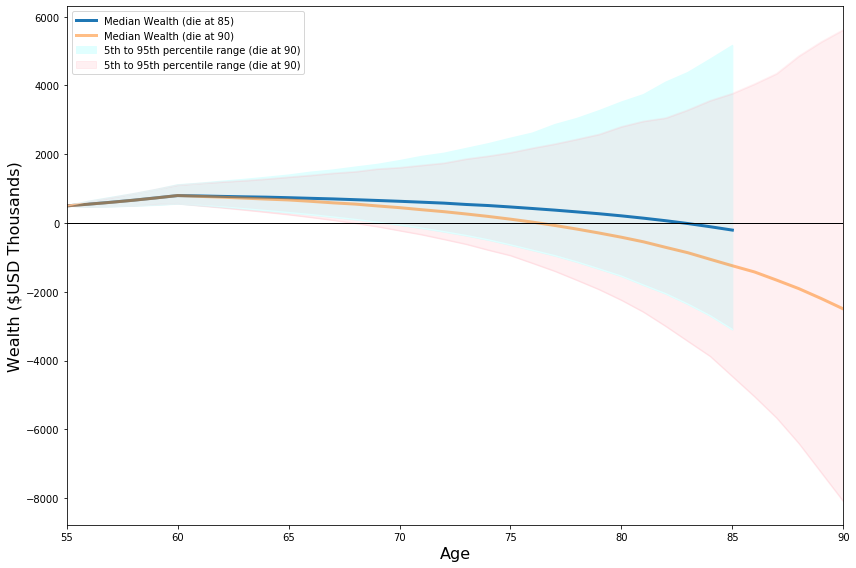

In [46]:

# Now run and plot the wealth/retirement simulation
perc_df_1, wealths_1 = get_wealths(W, N, start_wealth, L, corr_returns, spend=80, real=True)
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.lineplot(x=range(55,55+N+1), y=perc_df_1.columns[0], data=perc_df_1, color='lightcyan')
ax2 = sns.lineplot(x=range(55,55+N+1), y=perc_df_1.columns[1], data=perc_df_1, linewidth=3, label='Median Wealth (die at 85)')
ax3 = sns.lineplot(x=range(55,55+N+1), y=perc_df_1.columns[2], data=perc_df_1, color='lightcyan')
ax_line = sns.lineplot(x=range(55,55+N+1), y=1, linewidth=1, color='black')
ax1.fill_between(range(55,55+N+1), perc_df_1[perc_df_1.columns[0]], perc_df_1[perc_df_1.columns[2]], 
              color='lightcyan', alpha=1.00, label='5th to 95th percentile range (die at 90)')
# Check out what happens if person lives 5 years longer
N = pre_ret + post_ret + 5
corr_returns = []
for i in range(sims):
    corr_shocks = np.random.normal(0, 1, (N, exp_ret.shape[0]))@L.T
    corr_returns.append(np.matlib.repmat(exp_ret,N,1) + np.matlib.repmat(vol,N,1)*corr_shocks)

# Check out what happens if person spends 10K more annually    
perc_df_spend, wealths_spend = get_wealths(W, N, start_wealth, L, corr_returns, spend=spend+10, real=True)
ax1 = sns.lineplot(x=range(55,55+N+1), y=perc_df_spend.columns[0], data=perc_df_spend, color='lightpink', alpha=0.2)
ax2 = sns.lineplot(x=range(55,55+N+1), y=perc_df_spend.columns[1], data=perc_df_spend, linewidth=3, label='Median Wealth (die at 90)', alpha=0.5)
ax3 = sns.lineplot(x=range(55,55+N+1), y=perc_df_spend.columns[2], data=perc_df_spend, color='lightpink', alpha=0.2)
ax_line = sns.lineplot(x=range(55,55+N+1), y=1, linewidth=1, color='black')
ax1.fill_between(range(55,55+N+1), perc_df_spend[perc_df_1.columns[0]], perc_df_spend[perc_df_1.columns[2]], 
              color='lightpink', alpha=0.20, label='5th to 95th percentile range (die at 90)')


# Format and save the plot
ax.set_xlabel("Age",fontsize=16)
ax.set_ylabel("Wealth ($USD Thousands)",fontsize=16)
plt.legend(loc='upper left')
plt.xlim(55, 55+N)
plt.tight_layout()

plt.savefig(fname='port_return', dpi=150)
plt.show()


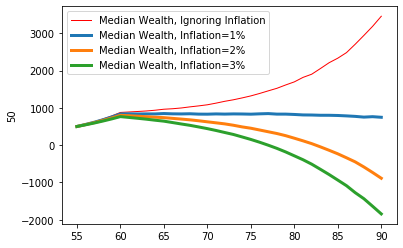

In [47]:
# For plotting median wealth at different levels of inflation
perc_df_0, wealths_0 = get_wealths(W, N, start_wealth, L, corr_returns, real=False, infl=0.00)
ax_inf0 = sns.lineplot(x=range(55,55+N+1), y=perc_df_0.columns[1], data=perc_df_0, linewidth=1, label='Median Wealth, Ignoring Inflation', color='red')
perc_df_1, wealths_1 = get_wealths(W, N, start_wealth, L, corr_returns, real=True, infl=0.01)
ax_inf1 = sns.lineplot(x=range(55,55+N+1), y=perc_df_1.columns[1], data=perc_df_1, linewidth=3, label='Median Wealth, Inflation=1%')
perc_df_2, wealths_2 = get_wealths(W, N, start_wealth, L, corr_returns, real=True, infl=0.02)
ax_inf2 = sns.lineplot(x=range(55,55+N+1), y=perc_df_2.columns[1], data=perc_df_2, linewidth=3, label='Median Wealth, Inflation=2%')
perc_df_3, wealths_3 = get_wealths(W, N, start_wealth, L, corr_returns, real=True, infl=0.03)
ax_inf3 = sns.lineplot(x=range(55,55+N+1), y=perc_df_3.columns[1], data=perc_df_3, linewidth=3, label='Median Wealth, Inflation=3%')


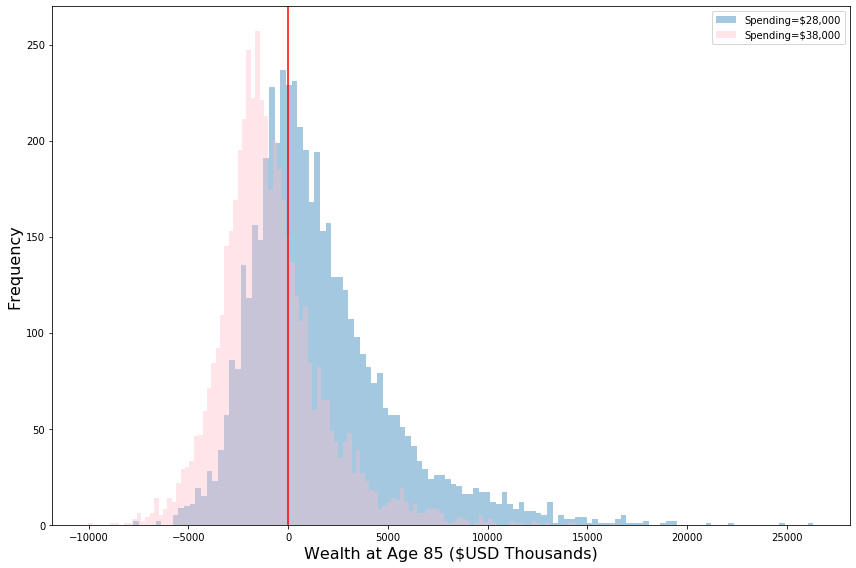

In [49]:
# Histogram that shows the distribution of the Monte Carlo Results for 2 spending levels
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(wealths_1.loc[30], kde=False, bins=120, label='Spending=$28,000')
sns.distplot(wealths_spend.loc[30], kde=False, bins=120, label='Spending=$38,000', color='pink')
plt.axvline(x=0, color='red')
# plt.xlim(-1500, 2000)

ax.set_xlabel("Wealth at Age 85 ($USD Thousands)",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.legend()
plt.tight_layout()

plt.savefig(fname='port_hist', dpi=150)
plt.show()


In [50]:
# Calculate the failure rate (frequency of running out of money)
len([i for i in wealths_1.loc[30] if i<0])/sims

0.3754

In [51]:
# Calculate the failure rate when spending is higher (frequency of running out of money)
len([i for i in wealths_spend.loc[30] if i<0])/sims

0.7078